# Vehicle Detection Project


## Objective
To detect cars and draw bounding boxes around them. See the writeup.md for full details.



### First: plotting functions

In [1]:
# First, define some handy functions for development and visualisation.
import cv2
import numpy as np
import glob
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neural_network import MLPClassifier
from sklearn.externals import joblib
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

# Define video function
def create_video( pipeline_in, input_video, output_video ):
    # Process video
    video = VideoFileClip( input_video )#.subclip( 38, 40 )
    video_processed = video.fl_image( pipeline_in )
    %time video_processed.write_videofile( output_video, audio=False )
    
# Define handy side by side plot function
def plot( image1, image2, title2):
    # Plot
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1, cmap='gray')
    ax1.set_title('Original', fontsize=30)
    ax1.axis('off')
    ax2.imshow(image2, cmap='gray')
    ax2.axis('off')
    ax2.set_title(title2, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return ax2

# Define draw boxes function
def draw_boxes(image, boxes, colour=(0, 0, 255), thickness=6):
    # Copy image
    draw_image = np.copy(image)
    
    # Draw each bounding box
    for box in boxes:
        cv2.rectangle(draw_image, box[0], box[1], colour, thickness)

    return draw_image

### Next: Create feature extraction functions

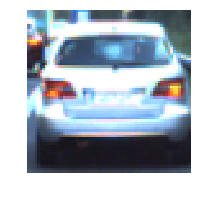

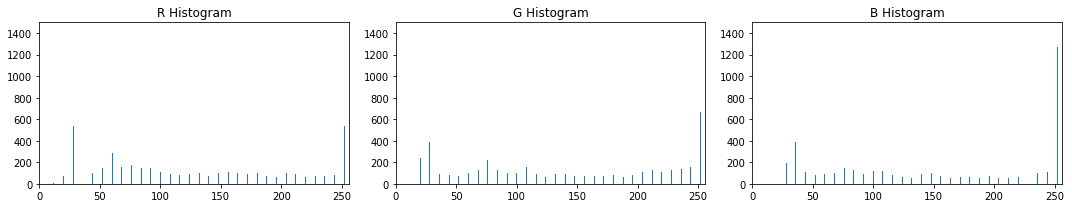

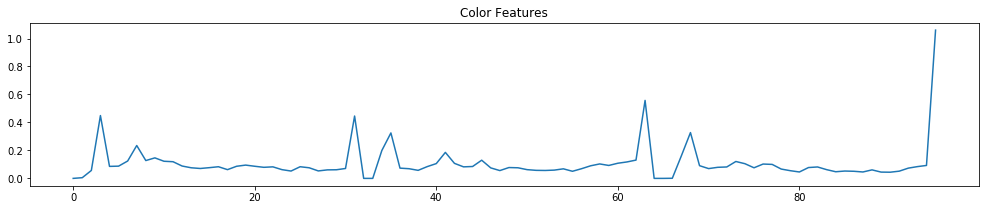

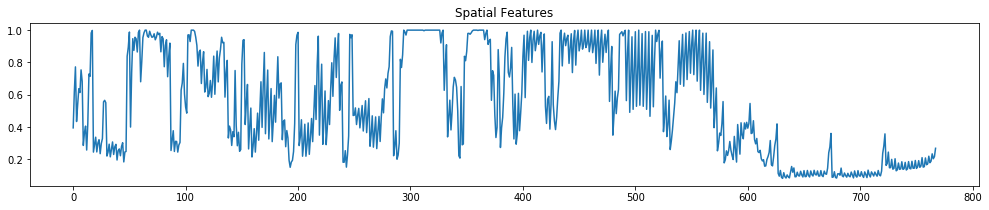

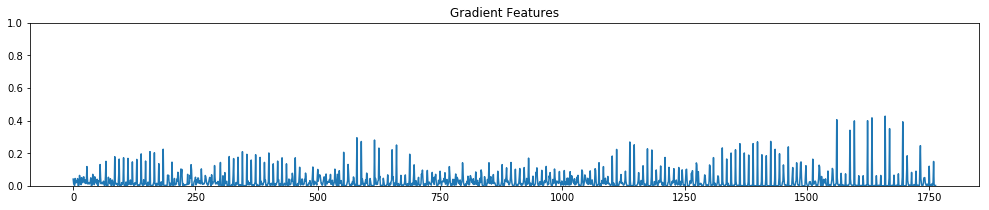

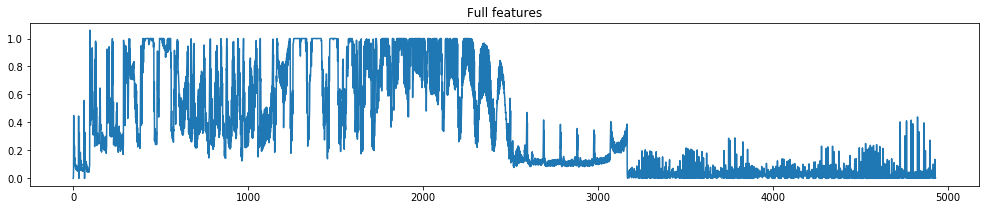

In [2]:
# Set extraction params
use_color_features = True     # Color histogram features on or off
use_spatial_features = True   # Spatial features on or off
use_gradient_features = True  # Gradient (HOG) features on or off
color_space = 'YUV'         # RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9                    # HOG orientations
pix_per_cell = 8              # HOG pixels per cell
cell_per_block = 2            # HOG cells per block
hog_channel = 'GRAY'           # Can be 0, 1, 2, "GRAY" or "ALL"
spatial_size = (32, 32)       # Spatial binning dimensions
hist_bins = 32                # Number of histogram bins

# Define a function to compute color histogram features  
def get_color_features(img, nbins, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
    
    # Concatenate the histograms into a single feature vector
    color_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
        
    # Return the individual histograms, bin_centers and feature vector
    return color_features/1200.0, rhist, ghist, bhist, bin_centers

# Define a function to compute spatial histogram features  
def get_spatial_features(img, size=(16, 16)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    
    # Return the feature vector
    return features/255.0

def get_gradient_features(image, hog_channel='ALL', orient=9, pix_per_cell=8, cell_per_block=2, feature_vec=True):
    
    # Test new HOG extractor
    winSize = (64, 64)
    blockSize = (16, 16)
    blockStride = (8, 8)
    cellSize = (8, 8)
    nbins = 9
    derivAperture = 1
    winSigma = 4.0
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 0
    nlevels = 64
    winStride = (8, 8)
    padding = (8, 8)
    locations = ((10, 20), )
#    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma,
#                            histogramNormType, L2HysThreshold, gammaCorrection, nlevels)
#    hist = hog.compute(image, winStride, padding, locations)
    
    if hog_channel == 'GRAY':
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        gradient_features = hog(gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
    elif hog_channel == 'ALL':
        gradient_features = []
        for channel in range(image.shape[2]):
            gradient_features.extend( hog(image[:, :, channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec) )
    else:
        gradient_features = hog(image[:,:,hog_channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
    return gradient_features
    
# Define a function to extract features
def extract_features(image,
                     color_space=color_space,
                     spatial_size=spatial_size,
                     hist_bins=hist_bins,
                     orient=orient, 
                     pix_per_cell=pix_per_cell,
                     cell_per_block=cell_per_block,
                     hog_channel=hog_channel,
                     use_spatial_features=use_spatial_features, 
                     use_color_features=use_color_features, 
                     use_gradient_features=use_gradient_features):
    
    # Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)  
    
    # Init
    spatial_features = []
    color_features = []
    gradient_features = []
    
    # Color features
    if use_color_features == True:
        color_features, _, _, _, _ = get_color_features(image, nbins=hist_bins)

    # Spatial features
    if use_spatial_features == True:
        spatial_features = get_spatial_features(image, size=spatial_size)
    
    # Gradient features
    if use_gradient_features == True:
        gradient_features = get_gradient_features(feature_image, hog_channel, orient, pix_per_cell, cell_per_block, feature_vec=True)

    # Return concatenated array of features
    features = np.concatenate((color_features, spatial_features, gradient_features))
    return features

# Test functions
image = mpimg.imread('test_images/31.png')
fig = plt.figure(figsize=(5, 3))
plt.imshow(image)
plt.axis( 'off' )

# Convert to 255 scale
image *= 255.0

# Get color features
color_features, rh, gh, bh, bincen = get_color_features(image, nbins=hist_bins)
fig = plt.figure(figsize=(15, 3))
plt.subplot(131)
plt.bar(bincen, rh[0])
plt.xlim(0, 256)
plt.ylim(0, 1500)
plt.title('R Histogram')
plt.subplot(132)
plt.bar(bincen, gh[0])
plt.xlim(0, 256)
plt.ylim(0, 1500)
plt.title('G Histogram')
plt.subplot(133)
plt.bar(bincen, bh[0])
plt.xlim(0, 256)
plt.ylim(0, 1500)
plt.title('B Histogram')
fig.tight_layout()
fig = plt.figure(figsize=(17, 3))
plt.plot(color_features)
plt.title('Color Features')
    
# Get spatial features
spatial_features = get_spatial_features(image)
fig = plt.figure(figsize=(17, 3))
plt.plot(spatial_features)
plt.title('Spatial Features')

# Get gradient features
gradient_features = get_gradient_features(image, hog_channel, orient, pix_per_cell, cell_per_block, feature_vec=True)
fig = plt.figure(figsize=(17, 3))
plt.plot(gradient_features)
plt.ylim(0, 1.0)
plt.title('Gradient Features')

# Combine into full feature vector to use
image_features = extract_features( image )
fig = plt.figure(figsize=(17, 3))
plt.plot(image_features)
plt.title('Full features')

## Extract features from training data

Number of cars: 8792
Number of non-cars: 8968
Extracting features for training...
Number of features: 4932
Number of cars: 8792
Number of notcars: 8968
X shape: (17760, 4932)


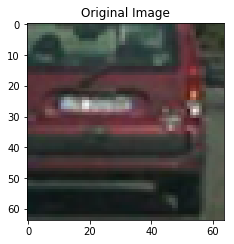

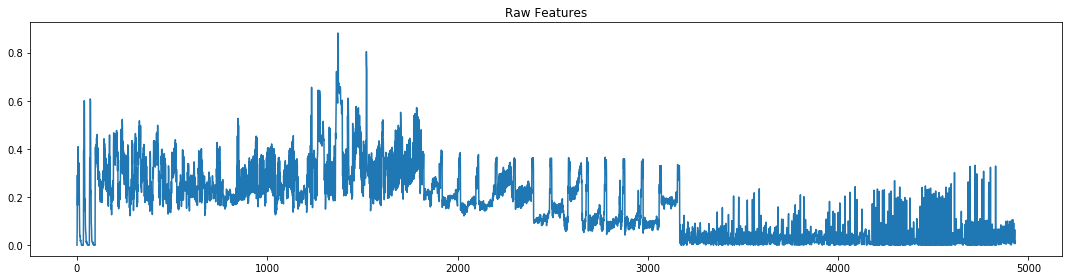

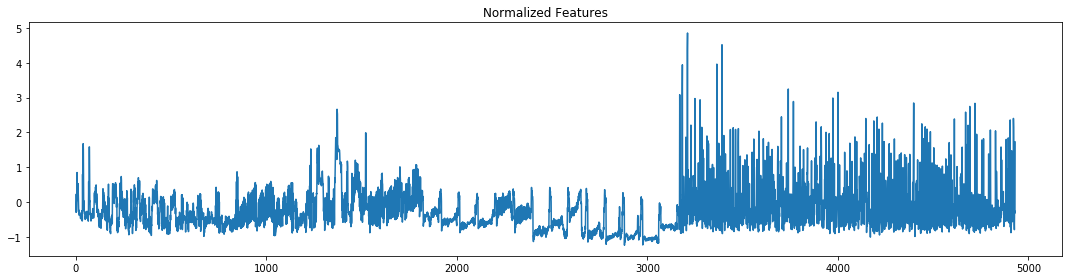

In [3]:
def extract_features_from_files(files):
    features = []
    for file in files:
        image = mpimg.imread(file)
        image *= 255.0
        image_features = extract_features( image )
        features.append(image_features)
    return features

# Read in our training vehicles and non-vehicles
images = glob.glob('./train_data/**/*.*', recursive=True)
cars = []
notcars = []
for image in images:
    if 'non' in image:
        notcars.append(image)
    else:
        cars.append(image)
print( "Number of cars: " + str( len( cars ) ) )
print( "Number of non-cars: " + str( len( notcars ) ) )

# Iterate through the list of images
print( "Extracting features for training..." )
car_features = extract_features_from_files(cars)
notcar_features = extract_features_from_files(notcars)

# Print shape
print( "Number of features: " + str( len(car_features[0]) ) )
print( "Number of cars: " + str( len(car_features) ) )
print( "Number of notcars: " + str( len(notcar_features) ) )

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
print( "X shape: " + str( X.shape ) )

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Plot an example of raw and scaled features
car_ind = np.random.randint(0, len(cars)) # Pick a random car
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')

fig = plt.figure(figsize=(15, 4))
plt.plot(X[car_ind])
plt.title('Raw Features')
fig.tight_layout()

fig = plt.figure(figsize=(15, 4))
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()


## Train our classifier

In [4]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
print('Number of features:', len(X_train[0]))

try:
    svc = joblib.load('model.pkl')
except:

    # Use a linear SVC 
    print('Training...')
    svc = LinearSVC()

    # Test new NN classifier
    #mlpc = MLPClassifier(alpha=1)

    # Train!
    t = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print('Seconds to train SVC: ', round(t2-t, 1) )
    print('Test Accuracy of SVC: ', round(svc.score(X_test, y_test), 5))

    # Check the prediction time for a single sample
    t = time.time()
    n_predict = 18
    print('My SVC predicts    : ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print( 'Seconds to predict', n_predict,'labels:', round(t2-t, 3))

    # Save
    joblib.dump(svc, 'model.pkl') 


Number of features: 4932


## Create search window generator

In [5]:
# Define a function that takes an image, start and stop positions in both x and y, 
# window size (x and y dimensions), and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int(np.ceil((xspan-nx_buffer)/nx_pix_per_step))
    ny_windows = np.int(np.ceil((yspan-ny_buffer)/ny_pix_per_step))
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows
    return window_list

## Create heatmap functions

In [6]:
def add_heat(heatmap, box_list):
    # Iterate through list of boxes
    for box in box_list:
        # Add 1 for all pixels inside each box, each box takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0

    # Return thresholded map
    return heatmap

def draw_labeled_boxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
        
    # Return the image
    return img

## Create function to search windows

In [7]:
def search_windows(img, windows, clf, scaler):
    
    # Create an empty list to receive positive detection windows
    on_windows = []

    # Iterate over all windows in the list
    for window in windows:
        
        # Extract the test window from original image, resize to 64, 64 like training data
        test_image = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        # Extract features for that window using single_img_features()
        test_features = extract_features(test_image)
        
        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(test_features)
        
        # Predict using your classifier
        prediction = clf.predict(test_features)
        
        # Show features per image window
        if False:
            fig = plt.figure(figsize=(15, 2))
            plt.subplot(131)
            plt.imshow(test_image)
            if prediction == 1:
                plt.title('Prediction: Yes!')
            plt.subplot(132)
            plt.plot(test_features)
            plt.title('Test Features')
            fig.tight_layout()
        
        # If positive then save the window
        if prediction == 1 and clf.decision_function(test_features) >= 2:
            on_windows.append(window)

    # Return windows for positive detections
    return on_windows

## The Pipeline

(-0.5, 1279.5, 719.5, -0.5)

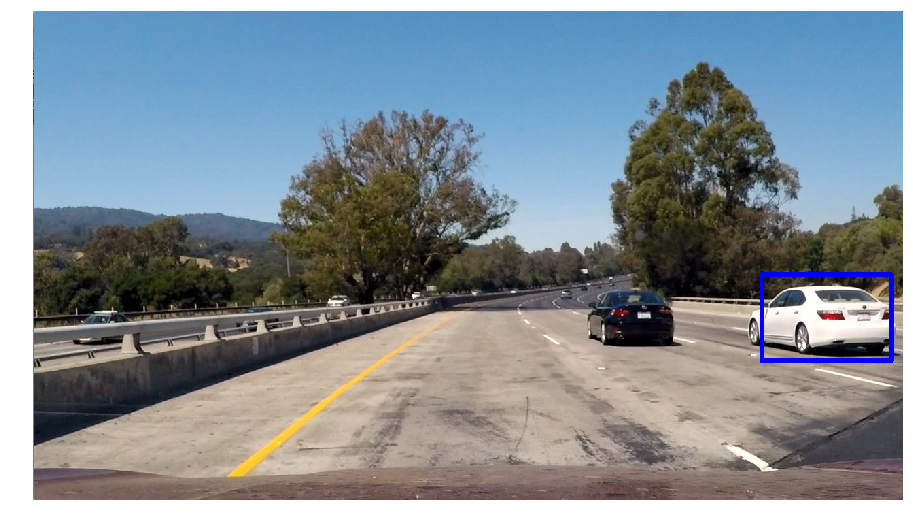

In [8]:
# Define pipeline
def pipeline(image):
    global heat
        
    # Search only in region 45% to 90% down the image (about bottom half)
    y_start_stop = (int(0.45 * image.shape[0]), int(0.90 * image.shape[0]))

    # Generate four layers of windows
    windows = []
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(128, 128), xy_overlap=(0.75, 0.75))
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(256, 256), xy_overlap=(0.75, 0.75))
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(350, 350), xy_overlap=(0.75, 0.75))
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(512, 512), xy_overlap=(0.75, 0.75))

    # Search those windows
    hot_windows = search_windows(image, windows, svc, X_scaler)
    
    # Draw boxes on those detected hot windows
    result = image
    if False: # Show raw detected windows
        result = draw_boxes(image, hot_windows, colour=(0, 150, 0), thickness=3)                    

    # Init heat if not already
    if heat == None:
        heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Heat cools
    heat *= 0.90
    
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)

    # Apply threshold to help remove false positives
    heat2 = apply_threshold(heat, 3)

    # Find final boxes from heatmap using label function
    labels = label(heat2)
    draw_img = draw_labeled_boxes(np.copy(result), labels)

    # Convert heat to color image, merge on top of image
    result = draw_img
    heat_clipped = np.clip(heat, 0, 255)
    heat_clipped *= 20
    heat_clipped = np.clip(heat_clipped, 0, 255)
    heat_clipped_color = np.dstack((heat_clipped, heat_clipped, heat_clipped)).astype(np.uint8)
    if False: # Show heat color
        result = cv2.addWeighted(draw_img, 1, heat_clipped_color, 1, 0)

    # Return the big mix of images
    return result

# Test on image
heat = None
image = mpimg.imread('test_images/test1.jpg')
window_img = pipeline(image)

# Show
fig = plt.figure(figsize=(18, 9))
plt.imshow(window_img)
plt.axis('off')

In [ ]:
# Create video
heat = None
create_video( pipeline, "test_video.mp4", "test_output.mp4" )

# Show video
HTML("""<video width="960" height="540" controls><source src="{0}"></video>""".format( "test_output.mp4" ))

[MoviePy] >>>> Building video test_output.mp4
[MoviePy] Writing video test_output.mp4


 97%|█████████▋| 38/39 [02:57<00:04,  4.57s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output.mp4 

CPU times: user 2min 52s, sys: 1.7 s, total: 2min 54s
Wall time: 2min 58s


In [ ]:
# Create video
heat = None
create_video( pipeline, "project_video.mp4", "project_output1.mp4" )

# Show video
HTML("""<video width="960" height="540" controls><source src="project_output.mp4"></video>""")

[MoviePy] >>>> Building video project_output1.mp4
[MoviePy] Writing video project_output1.mp4


  3%|▎         | 42/1261 [03:14<1:32:19,  4.54s/it]